In [1]:
%load_ext autoreload
%autoreload 2

import h5py
import scipy
import sympy
import pickle
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sympy import Symbol, zeros, Function, MatrixSymbol

# import created modules
from hamiltonian.states import CoupledBasisState
from hamiltonian.generate_hamiltonian import generate_X_hamiltonian_function, generate_B_hamiltonian_function, \
                                                generate_diagonalized_hamiltonian
from hamiltonian.utils import ni_range, matrix_to_states, find_exact_states, reduced_basis_hamiltonian, \
                                find_state_idx_from_state, reorder_evecs, generate_coupled_ground_states

from couplings.utils import ED_ME_mixed_state, collapse_matrices, generate_superoperator, \
                            generate_flat_superoperator, generate_sharp_superoperator
from couplings.generate_coupling import optical_coupling_matrix, generate_laser_D

from symbolic import generate_density_matrix_symbolic, generate_system_of_equations, generate_symbolic_hamiltonian,\
                        system_of_equations_to_lines, generate_symbolic_detunings
from symbolic.utils import subs_rabi_rate

from utils.plot_utils import set_fontsize
from utils import population, J_levels, J_slice, delete_J_level

In [2]:
script_dir = Path().parent.absolute()

## X-state

Define what states from the $X ^1\Sigma$ electronic state are to be included in the simulation.

In [5]:
#Define what states are to be included in the simulation
Js_g = [0,2] # J values to be included
I_F = 1/2 #Fluorine nuclear spin
I_Tl = 1/2 #Thallium nuclear spin

#Generate a list of approximate ground states. The exact ground states are determined within the main
#simulation function
ground_states_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                  for J  in Js_g
                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                  for mF in ni_range(-F, F+1)
                 ]

In [6]:
for s in ground_states_approx:
    s.print_state()

+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 2, F1 = 3/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 2, F1 = 3/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 2, F1 = 3/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 2, F1 = 3/2, F = 2, mF = -2, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 2, F1 = 3/2, F = 2, mF = -1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 2, F1 = 3/2, F = 2, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 2, F1 = 3/2, F = 2, mF = 1, I1 = 1/2, I2 = 1/2, P 

Now generate the J=0 to J=4 Hamiltonian to get the reduced X state Hamiltonian

In [7]:
fname_X = "TlF_X_state_hamiltonian_J0to4.pickle"
fname_transform = "UC_to_C_J0to4.pickle"

path_X = script_dir / "stored_data" / fname_X
path_transform = script_dir / "stored_data" / fname_transform

with open(path_X, 'rb') as f:
    H_X_uc = pickle.load(f)

with open(path_transform, 'rb') as f:
    S_transform = pickle.load(f)

H_X_uc = generate_X_hamiltonian_function(H_X_uc)

In [8]:
# generate coupled basis states
Jmin = 0
Jmax = 4
QN_X = generate_coupled_ground_states(ni_range(Jmin, Jmax + 1), electronic_state = 'X',
                                       parity = parity, Ω = 0, I_Tl = 1/2, 
                                       I_F = 1/2)

E = np.array([0,0,0])
# small magnetic field to ensure m_F is a good quantum number
B = np.array([0,0,0.001])

H_X = S_transform.conj().T @ H_X_uc(E,B) @ S_transform

# diagonalize the Hamiltonian
H_X_diag, V, V_ref_X = generate_diagonalized_hamiltonian(H_X, keep_order = True, return_V_ref = True)

# new set of quantum numbers:
QN_X_diag = matrix_to_states(V, QN_X)

ground_states = find_exact_states(ground_states_approx, H_X_diag, QN_X_diag, V_ref = V_ref_X)

H_X_red = reduced_basis_hamiltonian(QN_X_diag, H_X_diag, ground_states)

## B-state
Define what states from the $B ^3\Pi_1$ electronic state are to be included in the simulation. Only need the states that are coupled to J = 1 in the X-state by the laser.

In [9]:
#Define what states are to be included in the simulation

J = 1
F1 = 3/2
F = 1
#Generate a list of excited states. The exact excited states are determined within the main
#simulation function
excited_states_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='B', P = -1, Omega = 1)
                  for mF in ni_range(-F, F+1)
                 ]

Now generate the excited state Hamiltonian to get the reduced B state Hamiltonian

In [10]:
fname_B = "B_hamiltonians_symbolic_coupled_P_1to3.pickle"

path_B = script_dir / "stored_data" / fname_B

In [11]:
with open(path_B, 'rb') as f:
    H_B = pickle.load(f)

In [12]:
H_B = generate_B_hamiltonian_function(H_B)*2*np.pi

# generate coupled basis states
Jmin = 1
Jmax = 3
Ps = [-1,1]

QN_B = [CoupledBasisState(
                    F,mF,F1,J,I_F,I_Tl,P = P, Omega = 1, electronic_state='B'
                    )
        for J  in ni_range(Jmin, Jmax+1)
        for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
        for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
        for mF in ni_range(-F, F+1)
        for P in Ps
    ]


H_B_diag, V, V_ref_B = generate_diagonalized_hamiltonian(H_B, keep_order = True, return_V_ref = True)

# new set of quantum numbers:
QN_B_diag = matrix_to_states(V, QN_B)

excited_states = find_exact_states(excited_states_approx, H_B_diag, QN_B_diag, V_ref=V_ref_B)

H_B_red = reduced_basis_hamiltonian(QN_B_diag, H_B_diag, excited_states)

## Total Internal Hamiltonian

In [13]:
H_X_red[np.abs(H_X_red) < 0.1] = 0
H_B_red[np.abs(H_B_red) < 0.1] = 0

H_int = scipy.linalg.block_diag(H_X_red, H_B_red)
V_ref_int = np.eye(H_int.shape[0])

#Define Hamiltonian in the rotating frame (transformation not applied yet)
H_rot = H_int.copy()

#Define QN for the total Hamiltonian that includes both X and B
QN = ground_states + excited_states

## Laser coupling

In [14]:
#Define ground states for laser driven transition
Js = [0]
ground_states_laser_approx =  [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                                  for J  in Js
                                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                                  for mF in ni_range(-F, F+1)
                                 ]

#Define excited states for laser
excited_states_laser_approx = excited_states_approx

In [15]:
#Define the "main" states. These are used to calculate the detunings and Rabi rates for the transitions
ground_main_approx = 1*CoupledBasisState(J=0,F1=1/2,F=1,mF=1,I1=1/2,I2=1/2,electronic_state='X', P = 1, Omega = 0)
excited_main_approx = 1*CoupledBasisState(J=1,F1=3/2,F=1,mF=1,I1=1/2,I2=1/2, electronic_state='B', P = -1, Omega = 1)

In [23]:
ground_states_laser_1 = find_exact_states(
                                ground_states_laser_approx, H_rot, QN, V_ref = V_ref_int
                                )
excited_states_laser_1 = find_exact_states(
                                excited_states_laser_approx, H_rot, QN, V_ref = V_ref_int
                                )

H_laser_z_1 = optical_coupling_matrix(
                                    QN, 
                                    ground_states_laser, 
                                    excited_states_laser, 
                                    pol_vec = np.array([0,0,1]), 
                                    reduced = False
                                    )
H_laser_x_1 = optical_coupling_matrix(
                                    QN, 
                                    ground_states_laser, 
                                    excited_states_laser, 
                                    pol_vec = np.array([1,0,0]), 
                                    reduced = False
                                    )

In [24]:
# set small values to zero
H_laser_z_1[np.abs(H_laser_z_1) < 1e-3*np.max(np.abs(H_laser_z_1))] = 0
H_laser_x_1[np.abs(H_laser_x_1) < 1e-3*np.max(np.abs(H_laser_x_1))] = 0

In [25]:
ground_main_1 = find_exact_states([ground_main_approx], H_rot, QN, V_ref = V_ref_int)[0]
excited_main_1 = find_exact_states([excited_main_approx], H_rot, QN, V_ref = V_ref_int)[0]

ME_main_1 = ED_ME_mixed_state(
                        excited_main_1, ground_main_1, pol_vec = np.array([0,0,1])
                        )

ground_main_idx_1 = QN.index(ground_main_1)
excited_main_idx_1 = QN.index(excited_main_1)

print(ME_main_1)
ground_main_approx.print_state()
print('-'*100)
ground_main_1.print_state()
print('='*100)
excited_main_approx.print_state()
print('-'*100)
excited_main_1.print_state()

(-0.2714510958923855+0j)
+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
----------------------------------------------------------------------------------------------------
+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |B, J = 1, F1 = 3/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>
----------------------------------------------------------------------------------------------------
+0.8518+0.0000j x |B, J = 1, F1 = 3/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>
+0.5233+0.0000j x |B, J = 2, F1 = 3/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>


In [26]:
D1 = generate_laser_D(H_rot, QN, ground_main_1, excited_main_1, excited_states_laser_1, Δ = 0)

## Total Hamiltonian

In [27]:
H_rot = H_rot  - np.eye(H_rot.shape[0])*H_rot[ground_main_idx_1,ground_main_idx_1]
H_rot = H_rot + D1

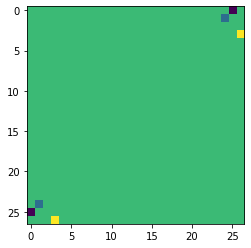

In [29]:
plt.imshow(H_laser_z_1.real)

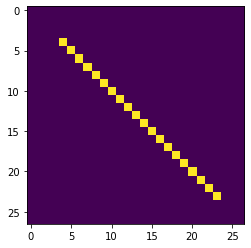

In [30]:
plt.imshow(H_rot.real)

In [31]:
Γ = 2*np.pi*1.6e6
C_list = collapse_matrices(QN, ground_states, excited_states, gamma = Γ)
C_array = np.array(C_list)
C_conj_array = np.einsum('ijk->ikj', C_array.conj())

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.82it/s]


In [170]:
t = Symbol("t", real = True)
Px1 = Function("Px1")(t) # Polarization switching function for x
Pz1 = Function("Pz1")(t) # Polarization switching function for z

laser_fields = [(H_laser_z_1*Pz1, ME_main_1), (H_laser_x_1*Px1, ME_main_1)]
detunings = [[QN.index(exc) for exc in excited_states]]

In [173]:
n_states = H_laser_z_1.shape[0]
excited_state_indices = [QN.index(exc_state) for exc_state in excited_states]
H_symbolic, Ωs = generate_symbolic_hamiltonian(n_states, laser_fields)
Δ_symbolic, Δs = generate_symbolic_detunings(n_states, detunings)
H_symbolic += Δ_symbolic + H_rot

In [174]:
H_symbolic

Matrix([
[             83586.7483305611,                            0,                            0,                            0,                0,                0,                0,                0,                0,                0,                0,                0,                0,                0,               0,                0,                0,               0,                0,                0,                0,                0,                0,                0, -0.755800578699364*Ω2*Px1(t),  1.06889211794367*Ω1*Pz1(t), 0.755841151210288*Ω2*Px1(t)],
[                            0,             40.7669399011647,                            0,                            0,                0,                0,                0,                0,                0,                0,                0,                0,                0,                0,               0,                0,                0,               0,                0,                0,               

In [175]:
H_symbolic = H_symbolic.subs(Ωs[1][0],Ωs[0][0]).subs(Ωs[1][1],Ωs[0][1])
H_symbolic

Matrix([
[             83586.7483305611,                            0,                            0,                            0,                0,                0,                0,                0,                0,                0,                0,                0,                0,                0,               0,                0,                0,               0,                0,                0,                0,                0,                0,                0, -0.755800578699364*Ω1*Px1(t),  1.06889211794367*Ω1*Pz1(t), 0.755841151210288*Ω1*Px1(t)],
[                            0,             40.7669399011647,                            0,                            0,                0,                0,                0,                0,                0,                0,                0,                0,                0,                0,               0,                0,                0,               0,                0,                0,               

In [176]:
system = generate_system_of_equations(H_symbolic, C_array, progress = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [01:15<00:00,  2.30s/it]


In [177]:
# convert matrix to system of equations code
code_lines = system_of_equations_to_lines(system)

# Solving ODE system with Julia
Need to install Julia and add the following packages to Julia:  
* [DifferentialEquations](https://diffeq.sciml.ai/stable/)
* [Trapz](https://github.com/francescoalemanno/Trapz.jl)

And install [PyJulia](https://pyjulia.readthedocs.io/en/latest/index.html) for python.  

In [178]:
# import julia
# julia.install()

In [41]:
from julia import Main

In [179]:
Main.eval("""
using Distributed
using BenchmarkTools
""")

if Main.eval("nprocs()") < 6:
    Main.eval("""
    addprocs(6)

    @everywhere begin
        using LinearAlgebra
        using Trapz
        using DifferentialEquations
        include("utils/general_ode_functions.jl")
    end
    """)

In [180]:
procs = Main.eval("procs()")
if len(procs) > 6:
    for p in procs[procs>6]:
        Main.eval(f"rmprocs({p})")

In [181]:
# Px = Main.eval("[sine_wave(ti, νp1, 4.71238898038469) for ti = range(0,1/νp1,length=101)]")
# Pz = Main.eval("[sine_wave(ti, νp1, 1.5707963267948966) for ti = range(0,1/νp1,length=101)]")
# normalization = np.sqrt(Px**2+Pz**2)
# plt.plot(np.array([Px,Pz]).T/normalization[:,np.newaxis])

## Creating the Julia function to compute the RHS of the Lindblad Equation
Note that only here the polarization switching function is added.  
Anything added symbolically can be modified here.

In [182]:
ode_fun = """function Lindblad_rhs!(du, ρ, p, t)
\t@inbounds begin
\t\tνp = p[2]
\t\tΔ = p[3]
\t\ty0 = p[4]
\t\tvy = p[5]
\t\tvz = p[6]
\t\tμzlaser = p[7]
\t\tσylaser = p[8]
\t\tσzlaser = p[9]
\t\tΩ1 = p[1]
\t\tΩ1 = Ω1 .* gaussian_2d(vz*t, y0+vy*t, 1., μzlaser, 0., σzlaser, σylaser)
\t\tΩ1ᶜ = conj(Ω1)
\t\tPx1 = sine_wave(t, νp, 4.71238898038469)
\t\tPz1 = sine_wave(t, νp, 1.5707963267948966)
\t\tnorm = sqrt(Px1^2+Pz1^2)
\t\tPx1 /= norm
\t\tPz1 /= norm
"""

In [183]:
print(ode_fun)

function Lindblad_rhs!(du, ρ, p, t)
	@inbounds begin
		νp = p[2]
		Δ = p[3]
		y0 = p[4]
		vy = p[5]
		vz = p[6]
		μzlaser = p[7]
		σylaser = p[8]
		σzlaser = p[9]
		Ω1 = p[1]
		Ω1 = Ω1 .* gaussian_2d(vz*t, y0+vy*t, 1., μzlaser, 0., σzlaser, σylaser)
		Ω1ᶜ = conj(Ω1)
		Px1 = sine_wave(t, νp, 4.71238898038469)
		Pz1 = sine_wave(t, νp, 1.5707963267948966)
		norm = sqrt(Px1^2+Pz1^2)
		Px1 /= norm
		Pz1 /= norm



In [184]:
for cline in code_lines:
    ode_fun += "\t\t"+cline+'\n'
ode_fun += '\t end \n \t nothing \n end'

In [185]:
# making the function in Julia
Main.eval(f"@everywhere {ode_fun}")

## Generate Density matrices for all three states

In [186]:
ρ_ini = np.zeros([n_states,n_states], dtype = 'complex')


ρ_ini_F0mF0 = ρ_ini.copy()
ρ_ini_F0mF0[0,0] = 1

ρ_ini_F1mF0 = ρ_ini.copy()
ρ_ini_F1mF0[2,2] = 1

ρ_ini_F1mF1 = ρ_ini.copy()
ρ_ini_F1mF1[1,1] = 0.5
ρ_ini_F1mF1[3,3] = 0.5

initial_populations = {
    "F=0, mF=0": ρ_ini_F0mF0,
    "F=1, mF=0": ρ_ini_F1mF0,
    "F=1, mF=1": ρ_ini_F1mF1
}

In [187]:
Γ = 2*np.pi*1.6e6

Ω =  0.06*Γ
ωp = Γ
νp = ωp/(2*np.pi)
Δ = 0
σylaser = 1e-2/2
σzlaser = 1e-2/2
μzlaser = 5*σzlaser

Main.Ω = Ω
Main.ωp = ωp
Main.νp = νp
Main.Δ = Δ
Main.Γ = Γ
Main.μzlaser = μzlaser
Main.σylaser = σylaser
Main.σzlaser = σzlaser

Main.ρ_ini = ρ_ini
Main.ρ_ini_F0mF0 = ρ_ini_F0mF0

# setting up the parameters to send to the differential equation
Main.eval("p = [Ω, νp, Δ, 0., 0., 184., μzlaser, σylaser, σzlaser]")

for par in 'Γ, Ω, Δ, ωp, νp, σylaser, σzlaser, μzlaser'.split(','):
    try:
        Main.eval(f"@eval @everywhere {par} = ${par}")
    except Exception as e:
        print(par)
        raise e
Main.eval("@eval @everywhere p = $p")

In [188]:
%%time
du = np.zeros(ρ_ini.shape, dtype = 'complex')
Main.du = du
Main.eval("""
@btime Lindblad_rhs!(du, ρ_ini_F0mF0, p, 0.)
tmp = 0
""")

Wall time: 5.35 s


0

### Setting up the ODE problem to solve
`tmp = 0` is just to prevent `Main.eval` from outputting the problem in the notebook.  
The ODEProblem takes a function to solve (`Lindblad_rhs!` in this case), initial conditions `ρ_ini`, a timespan `tspan` an additional arguments for the ODE function, denoted here by `p` 

In [189]:
Main.eval("""
tspan = (0.0f0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini_F0mF0,tspan,p)
tmp = 0
""")

0

In [190]:
Main.eval("""
@everywhere condition(u,t,integrator) = integrator.p[6]*t > 0.05
affect!(integrator) = terminate!(integrator)
cb = DiscreteCallback(condition, affect!)
""")

<PyCall.jlwrap DiscreteCallback{typeof(condition), typeof(affect!), typeof(DiffEqBase.INITIALIZE_DEFAULT), typeof(DiffEqBase.FINALIZE_DEFAULT)}(condition, affect!, DiffEqBase.INITIALIZE_DEFAULT, DiffEqBase.FINALIZE_DEFAULT, Bool[1, 1])>

In [191]:
%%time
Main.eval("""
@time sol = solve(prob, Tsit5(), abstol = 2.5e-7, reltol = 2.4e-4, callback = cb, dt = 1e-9)
trapz(sol.t, [real(sum(diag(sol.u[j])[25:end])) for j in 1:size(sol.u)[1]])
""")

Wall time: 1.61 s


1.6087427842765089e-07

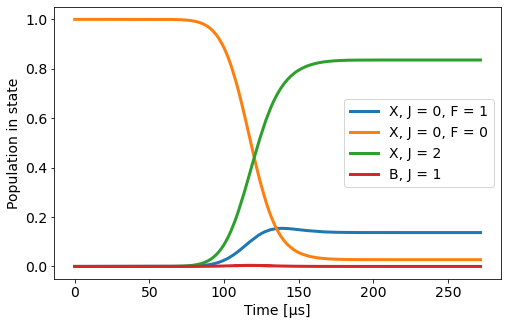

In [192]:
ut = np.array(Main.eval("sol[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("sol.t")

#Plot populations in different J over time when using the exponentiation method
P0_triplet = np.sum(pop_results[1:4,:], axis = 0)
P0_singlet = np.sum(pop_results[0:1,:], axis = 0)
P2 = np.sum(pop_results[4:24,:], axis = 0)
PB1 = np.sum(pop_results[24:,:], axis = 0)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t_array*1e6, P0_triplet, label = 'X, J = 0, F = 1', lw = 3)
ax.plot(t_array*1e6, P0_singlet, label = 'X, J = 0, F = 0', lw = 3)
ax.plot(t_array*1e6, P2, label = 'X, J = 2', lw = 3)
ax.plot(t_array*1e6, PB1, label = 'B, J = 1', lw = 3)
ax.legend(fontsize = 14)
ax.set_xlabel("Time [μs]")
ax.set_ylabel("Population in state")
set_fontsize(ax, 14)

## Parameter scan for $\Omega = 0.06\Gamma$

In [193]:
Main.Deltas = np.linspace(-3,3,101)*Γ
Main.params = Main.Deltas
Main.eval("@everywhere params = $params")

In [194]:
Main.eval("""
@everywhere function affect!(integrator)
    terminate!(integrator)
end
@everywhere condition(u,t,integrator) = integrator.p[6]*t > 0.05
cb = DiscreteCallback(condition, affect!)
""")

<PyCall.jlwrap DiscreteCallback{typeof(condition), typeof(affect!), typeof(DiffEqBase.INITIALIZE_DEFAULT), typeof(DiffEqBase.FINALIZE_DEFAULT)}(condition, affect!, DiffEqBase.INITIALIZE_DEFAULT, DiffEqBase.FINALIZE_DEFAULT, Bool[1, 1])>

In [195]:
# function called every time on the when an ODE solve is ready
# only save the integral of the excited state population of each trajectory
Main.eval("""
@everywhere function output_func(sol,i)
    # next!(pbar)
    return trapz(sol.t, [real(sum(diag(sol.u[j])[25:end])) for j in 1:size(sol.u)[1]]), false
end""")

In [196]:
Main.eval("@everywhere tspan = (0.0f0, 300e-6)")
results = {}
for name, ρ_ini in initial_populations.items():
    Main.ρ_ini = ρ_ini
    Main.eval("@eval @everywhere ρ_ini = $ρ_ini")
    Main.eval("""
    prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
    tmp = 0
    """)

    # defining the function that changes the ODE parameters for each iteration
    Main.eval("""
    @everywhere function prob_func(prob,i,repeat)
        remake(prob,p=[Ω, νp, params[i], 0., 0., 184, μzlaser, σylaser, σzlaser])
    end
    """)

    # setting up the EnsembleProblem with the earlier defined ODEProblem
    Main.eval("""
    ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)
    """)

    Main.eval("""
    @time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true, 
                save_everystep = true; trajectories = size(params)[1], dt = 1e-9, adaptive=true,
                abstol = 5e-7, reltol = 5e-4, callback = cb)
    sim.elapsedTime
    """)
    results[name] = Main.eval("sim.u")

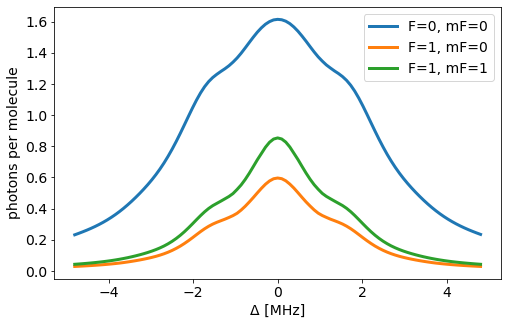

In [197]:
fig, ax = plt.subplots(figsize = (8,5))

for name, res in results.items():
    ax.plot(Main.Deltas/(2*np.pi*1e6), res*Γ, lw = 3, label = name)
    
ax.set_xlabel('Δ [MHz]')
ax.set_ylabel('photons per molecule')
ax.legend(fontsize = 14)

set_fontsize(ax, 14)

## Parameter scan for $\Omega = 0.18\Gamma$

In [198]:
Main.Deltas = np.linspace(-3,3,101)*Γ
Main.params = Main.Deltas
Main.eval("@everywhere params = $params")

In [199]:
Main.eval("@everywhere tspan = (0.0f0, 271.7391304347826e-6)")
results = {}
for name, ρ_ini in initial_populations.items():
    Main.ρ_ini = ρ_ini
    Main.eval("@eval @everywhere ρ_ini = $ρ_ini")
    Main.eval("""
    prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
    tmp = 0
    """)

    # defining the function that changes the ODE parameters for each iteration
    Main.eval("""
    @everywhere function prob_func(prob,i,repeat)
        remake(prob,p=[0.18Γ, νp, params[i], 0., 0., 184, μzlaser, σylaser, σzlaser])
    end
    """)

    # setting up the EnsembleProblem with the earlier defined ODEProblem
    Main.eval("""
    ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)
    """)

    # starting the parallel ensemble simulation
    # precision of the solver is increased resulting in a longer runtime
    # probably not necessary
#     Main.eval("pbar.counter = 0")
#     Main.eval("pbar.n = size(params)[1]")
    Main.eval("""
    @time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true, 
                save_everystep = true; trajectories = size(params)[1], dt = 1e-9, adaptive=true,
                abstol = 5e-7, reltol = 5e-4)
    sim.elapsedTime
    """)
    results[name] = Main.eval("sim.u")

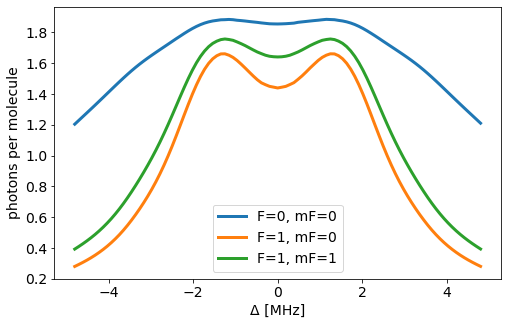

In [200]:
fig, ax = plt.subplots(figsize = (8,5))

for name, res in results.items():
    ax.plot(Main.Deltas/(2*np.pi*1e6), res*Γ, lw = 3, label = name)
    
ax.set_xlabel('Δ [MHz]')
ax.set_ylabel('photons per molecule')
ax.legend(fontsize = 14)

set_fontsize(ax, 14)

## Parameter scan for $\Omega = 0.5\Gamma$

In [201]:
Main.Deltas = np.linspace(-3,3,101)*Γ
Main.params = Main.Deltas
Main.eval("@everywhere params = $params")

In [202]:
Main.eval("@everywhere tspan = (0.0f0, 271.7391304347826e-6)")
results = {}
for name, ρ_ini in initial_populations.items():
    Main.ρ_ini = ρ_ini
    Main.eval("@eval @everywhere ρ_ini = $ρ_ini")
    Main.eval("""
    prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
    tmp = 0
    """)

    # defining the function that changes the ODE parameters for each iteration
    Main.eval("""
    @everywhere function prob_func(prob,i,repeat)
        remake(prob,p=[0.5Γ, νp, params[i], 0., 0., 184, μzlaser, σylaser, σzlaser])
    end
    """)

    # setting up the EnsembleProblem with the earlier defined ODEProblem
    Main.eval("""
    ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)
    """)

    # starting the parallel ensemble simulation
    # precision of the solver is increased resulting in a longer runtime
    # probably not necessary
#     Main.eval("pbar.counter = 0")
#     Main.eval("pbar.n = size(params)[1]")
    Main.eval("""
    @time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true, 
                save_everystep = true; trajectories = size(params)[1], dt = 1e-9, adaptive=true,
                abstol = 1e-8, reltol = 1e-5)
    sim.elapsedTime
    """)
    results[name] = Main.eval("sim.u")

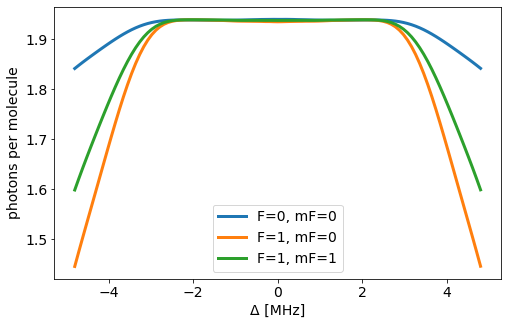

In [203]:
fig, ax = plt.subplots(figsize = (8,5))

for name, res in results.items():
    ax.plot(Main.Deltas/(2*np.pi*1e6), res*Γ, lw = 3, label = name)
    
ax.set_xlabel('Δ [MHz]')
ax.set_ylabel('photons per molecule')
ax.legend(fontsize = 14)

set_fontsize(ax, 14)

## Parameter scan for $\Omega = 0.18\Gamma$

No polarization modulation

In [204]:
Main.Deltas = np.linspace(-3,3,101)*Γ
Main.params = Main.Deltas
Main.eval("@everywhere params = $params")

In [205]:
Main.eval("@everywhere tspan = (0.0f0, 271.7391304347826e-6)")
results = {}
for name, ρ_ini in initial_populations.items():
    Main.ρ_ini = ρ_ini
    Main.eval("@eval @everywhere ρ_ini = $ρ_ini")
    Main.eval("""
    prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
    tmp = 0
    """)

    # defining the function that changes the ODE parameters for each iteration
    Main.eval("""
    @everywhere function prob_func(prob,i,repeat)
        remake(prob,p=[0.18Γ, 0, params[i], 0., 0., 184, μzlaser, σylaser, σzlaser])
    end
    """)

    # setting up the EnsembleProblem with the earlier defined ODEProblem
    Main.eval("""
    ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)
    """)

    # starting the parallel ensemble simulation
    # precision of the solver is increased resulting in a longer runtime
    # probably not necessary
#     Main.eval("pbar.counter = 0")
#     Main.eval("pbar.n = size(params)[1]")
    Main.eval("""
    @time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true, 
                save_everystep = true; trajectories = size(params)[1], dt = 1e-9, adaptive=true,
                abstol = 1e-8, reltol = 1e-5)
    sim.elapsedTime
    """)
    results[name] = Main.eval("sim.u")

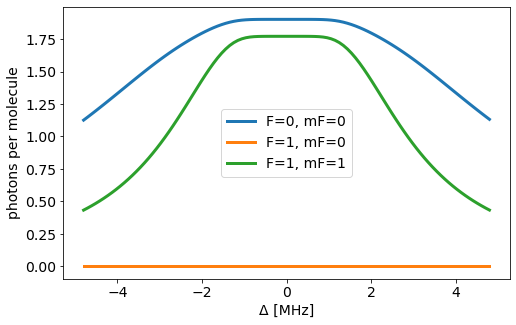

In [206]:
fig, ax = plt.subplots(figsize = (8,5))

for name, res in results.items():
    ax.plot(Main.Deltas/(2*np.pi*1e6), res*Γ, lw = 3, label = name)
    
ax.set_xlabel('Δ [MHz]')
ax.set_ylabel('photons per molecule')
ax.legend(fontsize = 14)

set_fontsize(ax, 14)

## Parameter scan for $\Omega = \Gamma$

In [207]:
Main.Deltas = np.random.permutation(np.linspace(-5,5,101)*Γ)
Main.params = Main.Deltas
Main.eval("@everywhere params = $params")

In [208]:
results_higherpower = {}
Main.eval("@everywhere tspan = (0.0f0, 271.7391304347826e-6)")
for name, ρ_ini in initial_populations.items():
    Main.ρ_ini = ρ_ini
    Main.eval("""
    prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
    tmp = 0
    """)
    # defining the function that changes the ODE parameters for each iteration
    Main.eval("""
    @everywhere function prob_func(prob,i,repeat)
        remake(prob,p=[Γ, νp, params[i], 0., 0., 184, μzlaser, σylaser, σzlaser])
    end
    """)

    # setting up the EnsembleProblem with the earlier defined ODEProblem
    Main.eval("""
    ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)
    """)

    # starting the parallel ensemble simulation
    # precision of the solver is increased resulting in a longer runtime
    # probably not necessary
    Main.eval("""
    @time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true, 
                save_everystep = true; trajectories = size(params)[1], dt = 1e-9, adaptive=true,
                abstol = 1e-8, reltol = 1e-5)
    sim.elapsedTime
    """)
    results_higherpower[name] = Main.eval("sim.u")

In [209]:
sort_indices = np.argsort(Main.Deltas)
scan = Main.Deltas[sort_indices]

for name, res in results_higherpower.items():
    results_higherpower[name] = res[sort_indices]

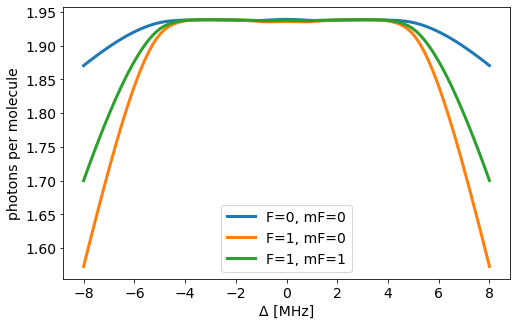

In [210]:
fig, ax = plt.subplots(figsize = (8,5))

for name, res in results_higherpower.items():
    ax.plot(scan/(2*np.pi*1e6), res*Γ, lw = 3, label = name)
    
ax.set_xlabel('Δ [MHz]')
ax.set_ylabel('photons per molecule')
ax.legend(fontsize = 14)

set_fontsize(ax, 14)